### Generate the tuning hyperparameters
In order to fairly evaluate the algorithms, the hyperparameters need to be tuned.
I use random tuning.
This script outputs a text file for hyperparameters.
Each line of the text file can be passed as a command line argument to `run_experiment.py`

In [160]:
# imports
import numpy as np
import pandas as pd
import random
import os
import re
import ast
import pickle
import matplotlib.pyplot as plt

In [212]:
# define hyperparameters and sampling ranges
random.seed(42)

# things to hit
_agent=["DQN","UADQN"]
_action_selection=["softmax", "egreedy"]
_seed = [1]
_n_episodes = [100]

# things to sample from
_lr = [1e-1, 7e-2, 3e-2, 1e-2, 7e-3, 3e-3, 1e-3, 7e-4, 3e-4, 1e-4, 7e-5, 3e-5, 1e-5]
_batch_size = [1, 2, 4, 8, 16, 32, 64, 128, 256]
_adam_epsilon = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
_update_target = [4, 8, 16, 32]
_epsilon_final = [0.1, 0.08, 0.06, 0.04, 0.03, 0.02, 0.01]

# generate samples
result = ""
#DQN
for action_selection in _action_selection:
    for n_episodes in _n_episodes:
        for _ in range(200):
            for seed in _seed:
                line = '--agent=DQN '
                line += '--action_selection='+action_selection+ ' '
                line += '--n_episodes='+str(n_episodes) + " "

                line += '--lr='+str(random.sample(_lr,1)[0]) + " "
                line += '--batch_size='+str(random.sample(_batch_size,1)[0]) + " "
                line += '--adam_epsilon='+str(random.sample(_adam_epsilon,1)[0]) + " "
                line += '--update_target='+str(random.sample(_update_target,1)[0]) + " "
                if action_selection=="egreedy":
                    line += '--epsilon_final='+str(random.sample(_epsilon_final,1)[0]) + " "


                result += line + '--seed='+str(seed) + "\n"
# UADQN
for n_episodes in _n_episodes:
    for _ in range(100):
        for seed in _seed:
            line = '--agent=UADQN '
            line += '--n_episodes='+str(50) + " "

            line += '--lr='+str(random.sample(_lr,1)[0]) + " "
            line += '--batch_size='+str(random.sample(_batch_size,1)[0]) + " "
            line += '--adam_epsilon='+str(random.sample(_adam_epsilon,1)[0]) + " "
            line += '--update_target='+str(random.sample(_update_target,1)[0]) + " "


            result += line + '--seed='+str(seed) + "\n"

# write text file

with open("tuning.txt", "w") as f:
    f.write(result)

### Evaluate Tuning Results
After the tuning runs, the results are stored in the `results` folder.
I read them in and generate files `tuned_hyperparameters_DQN_softmax.txt`, `tuned_hyperparameters_DQN_egreedy.txt`, `tuned_hyperparameters_UADQN.txt` with the optimal hyperparameter values for the three algorithms.

In [280]:
tuning_results="../../results/"
# read results
run_folders = [tuning_results+s for s in os.listdir(tuning_results) if s.startswith("2022")] 

params = []
episode_scores = []
for run_folder in run_folders:
    with open(run_folder+"/experimental-setup", "r") as setup:
        setup_dict = ast.literal_eval(setup.read())
        setup_dict["agent"] = "UADQN" if re.search(r"UADQN", run_folder) else "DQN"
        params.append(setup_dict)
    try:
        with open(run_folder+"/log_data.pkl", "rb") as scores:
            episode_scores.append([score for score, ts in pickle.load(scores)["Episode_score"]])
    except (FileNotFoundError):
        episode_scores.append("")
        print(run_folder)

../../results/2022-12-07-153208-CityLearn-DQN99
../../results/2022-12-07-164459-CityLearn-DQN155
../../results/2022-12-07-155108-CityLearn-DQN116
../../results/2022-12-07-150258-CityLearn-DQN78
../../results/2022-12-07-160112-CityLearn-DQN122
../../results/2022-12-07-164258-CityLearn-DQN153
../../results/2022-12-08-164047-CityLearn-UADQN487
../../results/2022-12-08-153112-CityLearn-UADQN453
../../results/2022-12-08-154150-CityLearn-UADQN464
../../results/2022-12-08-153016-CityLearn-UADQN444
../../results/2022-12-08-164101-CityLearn-UADQN488
../../results/2022-12-07-142611-CityLearn-DQN57
../../results/2022-12-08-142447-CityLearn-UADQN427
../../results/2022-12-08-164022-CityLearn-UADQN486
../../results/2022-12-07-143254-CityLearn-DQN61
../../results/2022-12-07-150518-CityLearn-DQN83
../../results/2022-12-07-161623-CityLearn-DQN132
../../results/2022-12-07-151732-CityLearn-DQN93
../../results/2022-12-07-134514-CityLearn-DQN23
../../results/2022-12-07-165930-CityLearn-DQN170
../../results

In [288]:
# generate dataframes:
setups = pd.DataFrame(params)
scores = pd.DataFrame(episode_scores)
#plt.plot(scores, alpha = 0.1, color="blue")
#setups


In [304]:
setups["final_score"] = scores[99]
setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]


#dqn-softmax
dqn_softmax_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].index
dqn_softmax_best_i = setups["final_score"][dqn_softmax_is].idxmax()


#dqn-egreedy
dqn_egreedy_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].index
dqn_egreedy_best_i = setups["final_score"][dqn_egreedy_is].idxmax()


#uadqn
uadqn_is = setups[setups["agent"] == "UADQN"].index
uadqn_best_i = setups["final_score"][uadqn_is].idxmax()



/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/2184603194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  setups["final_score"][setups["final_score"] != 0] = scores[49][setups["final_score"] != 0]
/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/2184603194.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dqn_softmax_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].index
/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/2184603194.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dqn_egreedy_is = setups[setups["agent"] == "DQN"][setups["action_selection"] == "egreedy"].index


In [305]:
setups["final_score"][uadqn_is]


8     -3247.470439
20     -860.147211
29    -1082.025613
30    -1065.068116
32     -837.084745
          ...     
478    -811.196263
487    -999.512246
489   -1390.878458
491   -4436.785795
496   -1050.798388
Name: final_score, Length: 100, dtype: float64

In [307]:

print("Best UADQN:", setups["final_score"][uadqn_best_i])
print("Best Softmax DQN:", setups["final_score"][dqn_softmax_best_i])
print("Best egreedy DQN:", setups["final_score"][dqn_egreedy_best_i])

setups[setups.index == dqn_softmax_best_i]["minibatch_size"]

Best UADQN: -583.7762383299705
Best Softmax DQN: -841.245053326973
Best egreedy DQN: -1076.2432608886447


72    128
Name: minibatch_size, dtype: int64

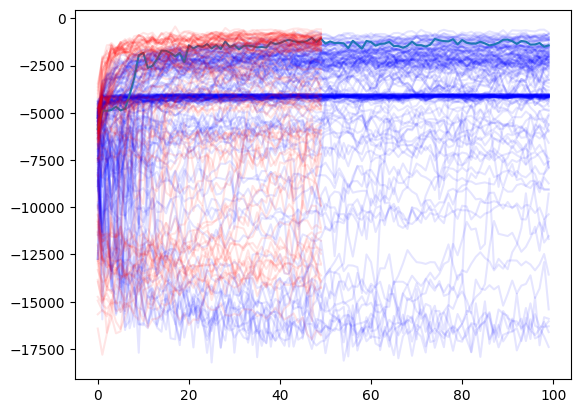

In [310]:
plt.plot(scores.transpose()[dqn_softmax_is], alpha = 0.1, color="blue")
plt.plot(scores.transpose()[dqn_egreedy_best_i])
plt.plot(scores.transpose()[uadqn_is], color="red", alpha=0.1)

### Generate Tuning Plots
From the tuning results, some things can be visualized:

For every algorithm:
1. the effect of individual hyperparameters on performance
2. ...
3. ...

In [260]:
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("adam_epsilon").mean()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby(["learning_rate"]).mean()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("update_target_frequency").describe()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("minibatch_size").describe()["final_score"]
# setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("adam_epsilon").mean()["final_score"]

/var/folders/xk/q5r2r6d96n34m06fwvg751s40000gn/T/ipykernel_19378/3220565413.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  setups[setups["agent"] == "DQN"][setups["action_selection"] == "softmax"].groupby("update_target_frequency").describe()["final_score"]


,count,mean,std,min,25%,50%,75%,max
update_target_frequency,,,,,,,,
4,43.0,-4866.953357,4238.148009,-17396.068381,-4165.127637,-4091.612713,-2400.983406,-745.614965
8,49.0,-4050.170377,3084.289193,-15407.512165,-4160.305691,-4030.212545,-2199.325212,-806.228696
16,47.0,-3199.460829,1716.603925,-7928.302772,-4152.643491,-2607.799550,-1796.753679,-851.394563
32,43.0,-3737.510232,2932.281986,-16609.450819,-4153.863653,-3269.503657,-1715.166944,-826.116852


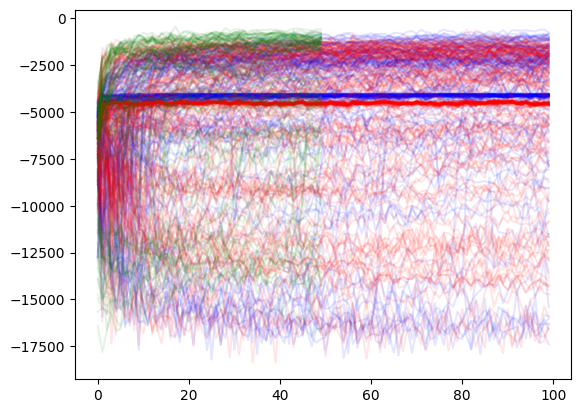

In [312]:
plt.plot(scores.transpose()[dqn_softmax_is], alpha=0.1, color="blue")
plt.plot(scores.transpose()[dqn_egreedy_is], alpha=0.1, color="red")
plt.plot(scores.transpose()[uadqn_is], alpha=0.1, color="green")